### How well do jobs and skills pay for Machine Learning Engineers?

#### Methology
1. Evaluate median salary for top 6 data jobs
2. Find median salary per skill for Data Analysts
3. Visualize for highest paying skills and most demanded skills

## Import Libraries

In [1]:
# let's inistall the libraries first 
!pip install -q datasets
!pip install -q adjustText
!pip install -q requests


In [2]:
# WE can now import all of the necessary libraries
import ast
import pandas as pd
import seaborn as sns
from datasets import load_dataset
import matplotlib.pyplot as plt 
import requests # to get the continents for the jobs

## Load Dataset

In [3]:
# Loading Data
dataset = load_dataset('lukebarousse/data_jobs')
df = dataset['train'].to_pandas()

## Data Cleanup


In [4]:
# Data Cleanup
df['job_posted_date'] = pd.to_datetime(df['job_posted_date'])
df['job_skills'] = df['job_skills'].apply(lambda x: ast.literal_eval(x) if pd.notna(x) else x)

In [5]:
# country for analysis and per continent analysis as well
df_country = df['job_country'].value_counts().to_frame(name='count')
df_country.reset_index(inplace=True)
df_country.rename(columns={'index':'Country'},inplace=True)
df_country.drop(columns='count',inplace=True)
df_country.head()

,Country
0,United States
1,India
2,United Kingdom
3,France
4,Germany


In [6]:
def get_continent(country):
    try:
        # Use the RestCountries API to fetch country information
        response = requests.get(f'https://restcountries.com/v3.1/name/{country}')
        data = response.json()
        return data[0]['continents'][0]  
    except Exception as e:
        return 'Unknown'


# Apply the function to the job_country column
df_country['continent'] = df_country['Country'].apply(get_continent)

In [7]:

fix_continents = {
    "United States": "North America",
    "Australia": "Oceania",
    "New Zealand": "Oceania",
    "Guam": "Oceania",
    "U.S. Virgin Islands": "North America",
    "Macedonia (FYROM)": "Europe",
    "Congo, Democratic Republic of the": "Africa",
    "Fiji": "Oceania",
    "Papua New Guinea": "Oceania",
    "Northern Mariana Islands": "Oceania"
}

# Update the continent column based on the mapping
df_country['continent'] = df_country['Country'].map(fix_continents).fillna(df_country['continent'])

In [8]:
df_merged = df.merge(df_country, how='left',left_on='job_country',right_on='Country')
df_merged.head(3)

,job_title_short,job_title,job_location,job_via,job_schedule_type,job_work_from_home,search_location,job_posted_date,job_no_degree_mention,job_health_insurance,job_country,salary_rate,salary_year_avg,salary_hour_avg,company_name,job_skills,job_type_skills,Country,continent
0,Senior Data Engineer,Senior Clinical Data Engineer / Principal Clin...,"Watertown, CT",via Work Nearby,Full-time,False,"Texas, United States",2023-06-16 13:44:15,False,False,United States,None,NaN,NaN,Boehringer Ingelheim,None,None,United States,North America
1,Data Analyst,Data Analyst,"Guadalajara, Jalisco, Mexico",via BeBee México,Full-time,False,Mexico,2023-01-14 13:18:07,False,False,Mexico,None,NaN,NaN,Hewlett Packard Enterprise,"[r, python, sql, nosql, power bi, tableau]","{'analyst_tools': ['power bi', 'tableau'], 'pr...",Mexico,North America
2,Data Engineer,"Data Engineer/Scientist/Analyst, Mid or Senior...","Berlin, Germany",via LinkedIn,Full-time,False,Germany,2023-10-10 13:14:55,False,False,Germany,None,NaN,NaN,ALPHA Augmented Services,"[python, sql, c#, azure, airflow, dax, docker,...","{'analyst_tools': ['dax'], 'cloud': ['azure'],...",Germany,Europe


#### Salary Distribution by Job Title

In [9]:
df_ml = df_merged[df_merged['salary_year_avg'].notna()]

df_ml_africa = df_merged[(df_merged['continent'] == 'Africa') & (df_merged['salary_year_avg'].notna())]

df_ml.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22003 entries, 28 to 785692
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   job_title_short        22003 non-null  object        
 1   job_title              22003 non-null  object        
 2   job_location           21723 non-null  object        
 3   job_via                22003 non-null  object        
 4   job_schedule_type      21987 non-null  object        
 5   job_work_from_home     22003 non-null  bool          
 6   search_location        22003 non-null  object        
 7   job_posted_date        22003 non-null  datetime64[ns]
 8   job_no_degree_mention  22003 non-null  bool          
 9   job_health_insurance   22003 non-null  bool          
 10  job_country            22003 non-null  object        
 11  salary_rate            22003 non-null  object        
 12  salary_year_avg        22003 non-null  float64       
 13 

In [10]:
job_titles = df_ml['job_title_short'].value_counts().index[:6].tolist()

# filter the df for the top 6 job titles
df_ml_top6 = df_ml[df_ml['job_title_short'].isin(job_titles)]
# order the job titles by median salary
job_order = df_ml_top6.groupby('job_title_short')['salary_year_avg'].median().sort_values(ascending=False).index


## Africa Dataset
job_titles = df_ml_africa['job_title_short'].value_counts().index[:6].tolist()
# filter the df for the top 6 job titles
df_ml_africa_top6 = df_ml_africa[df_ml_africa['job_title_short'].isin(job_titles)]
# order the job titles by median salary
job_order = df_ml_africa_top6.groupby('job_title_short')['salary_year_avg'].median().sort_values(ascending=False).index


job_titles

['Data Scientist',
 'Data Engineer',
 'Senior Data Scientist',
 'Data Analyst',
 'Senior Data Engineer',
 'Business Analyst']

#### Plot Salary Distributions

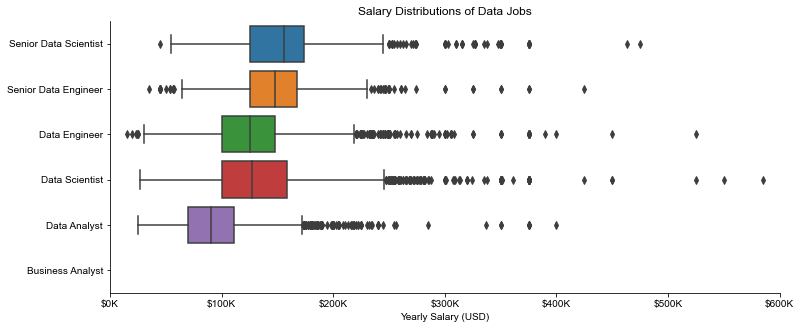

In [11]:
plt.figure(figsize=(12, 5))
sns.boxplot(data=df_ml_top6, x='salary_year_avg', y='job_title_short', order=job_order)
sns.set_theme(style='ticks')
sns.despine()

# this is all the same
plt.title('Salary Distributions of Data Jobs')
plt.xlabel('Yearly Salary (USD)')
plt.ylabel('')
plt.xlim(0, 600000) 
ticks_x = plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K')
plt.gca().xaxis.set_major_formatter(ticks_x)
plt.show()

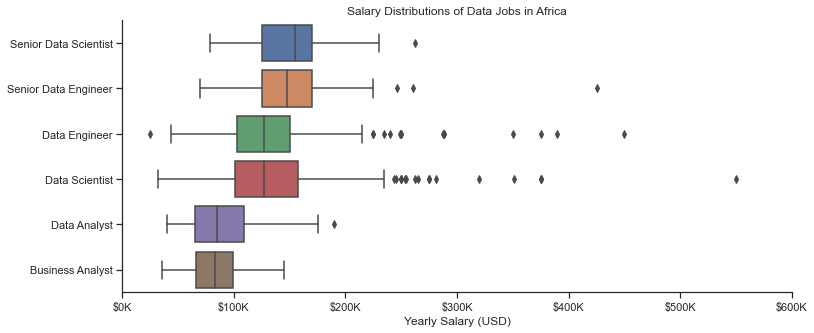

In [12]:
#Africa:- Top 6 jobs in Salary Distribtuion
plt.figure(figsize=(12, 5))
sns.boxplot(data=df_ml_africa_top6, x='salary_year_avg', y='job_title_short', order=job_order)
sns.set_theme(style='ticks')
sns.despine()

# this is all the same
plt.title('Salary Distributions of Data Jobs in Africa')
plt.xlabel('Yearly Salary (USD)')
plt.ylabel('')
plt.xlim(0, 600000) 
ticks_x = plt.FuncFormatter(lambda y, pos: f'${int(y/1000)}K')
plt.gca().xaxis.set_major_formatter(ticks_x)
plt.show()

#### Investigate the Median Salary vs Skill for MLEs

Filters the original dataset to only get rows where the job title is 'Machine Learning Engineer' and asl in the continent of 'Africa', to create a new DataFrame `df_ml`. Drop NaN values from the 'salary_year_avg' column. Then it uses the `explode` method on the `job_skills` column to create a new row in the DataFrame for each skill associated with a job. Finally, it displays the first five entries of the `salary_year_avg` and `job_skills` columns.

In [13]:
# Only get machine learning / data scientist jobs
df_ml_ = df_ml[df_ml['job_title_short'].isin(['Data Scientist','Machine Learning Engineer'])].copy()

# Drop NaN values from the 'salary_year_avg' column for accurate visualization
df_ml_ = df_ml_.dropna(subset=['salary_year_avg'])
df_ml_ = df_ml_.explode('job_skills')



# Only get machine learning / data scientist jobs in Africa
df_ml_africa_ = df_ml_africa[df_ml_africa['job_title_short'].isin(['Data Scientist','Machine Learning Engineer'])].copy()
# Drop NaN values from the 'salary_year_avg' column for accurate visualization
df_ml_africa_ = df_ml_africa_.dropna(subset=['salary_year_avg'])
df_ml_africa_ = df_ml_africa_.explode('job_skills')

In [14]:
df_ml_[['salary_year_avg', 'job_skills','continent']].head(5)

,salary_year_avg,job_skills,continent
28,109500.0,gdpr,North America
28,109500.0,excel,North America
100,228222.0,sql,North America
100,228222.0,r,North America
100,228222.0,python,North America


In [15]:
df_ml_africa_[['salary_year_avg', 'job_skills','continent']].head(5)

,salary_year_avg,job_skills,continent
5862,325000.0,python,Africa
5862,325000.0,java,Africa
5862,325000.0,sql,Africa
5862,325000.0,aws,Africa
5862,325000.0,gcp,Africa


#### Determine The Highest Paid Skills and Most Demanded Skills

Gets the top ten highest-paying skills for Machine Learning Engineers by calculating the median salary for each skill listed in the `df_ml_`. It groups the data by job skills, computes the median salary, sorts these values in descending order by median, and then selects the top 10. This is then formatted into a new DataFrame (`df_ml_top_pay`) with a reset index and a renamed salary column labeled 'median_salary'. We shall do the same for the Africa dataset as well.

In [16]:
df_ml_top_pay = df_ml_.groupby('job_skills')['salary_year_avg'].agg(['count', 'median']).sort_values(by='median', ascending=False)
df_ml_top_pay = df_ml_top_pay.head(10)

#Africa df
df_ml_africa_top_pay = df_ml_africa_.groupby('job_skills')['salary_year_avg'].agg(['count', 'median']).sort_values(by='median', ascending=False)
df_ml_africa_top_pay = df_ml_africa_top_pay.head(10)

df_ml_africa_top_pay

,count,median
job_skills,,
neo4j,1,250000.0
datarobot,2,235975.0
gdpr,2,216250.0
airtable,1,215500.0
watson,2,212500.0
ruby,6,199000.0
codecommit,1,191900.0
terraform,2,182500.0
node,1,180000.0


Calculates the count and median salary for each skill in `df_ml_`. It groups the data by `job_skills`, aggregates it to find the count and median salary for each skill, and then sorts the results by count in descending order by count. It re-sorts this subset by median salary in descending order.

In [17]:
df_ml_skills = df_ml_.groupby('job_skills')['salary_year_avg'].agg(['count', 'median']).sort_values(by='count', ascending=False)
df_ml_skills = df_ml_skills.head(10).sort_values(by='median', ascending=False)

#Africa df
df_ml_africa_skills = df_ml_africa_.groupby('job_skills')['salary_year_avg'].agg(['count', 'median']).sort_values(by='count', ascending=False)
df_ml_africa_skills = df_ml_africa_skills.head(10).sort_values(by='median', ascending=False)

df_ml_skills.head()

,count,median
job_skills,,
pytorch,752,145000.0
tensorflow,834,140000.0
spark,1058,135959.5
sql,3260,132500.0
aws,1196,131655.0


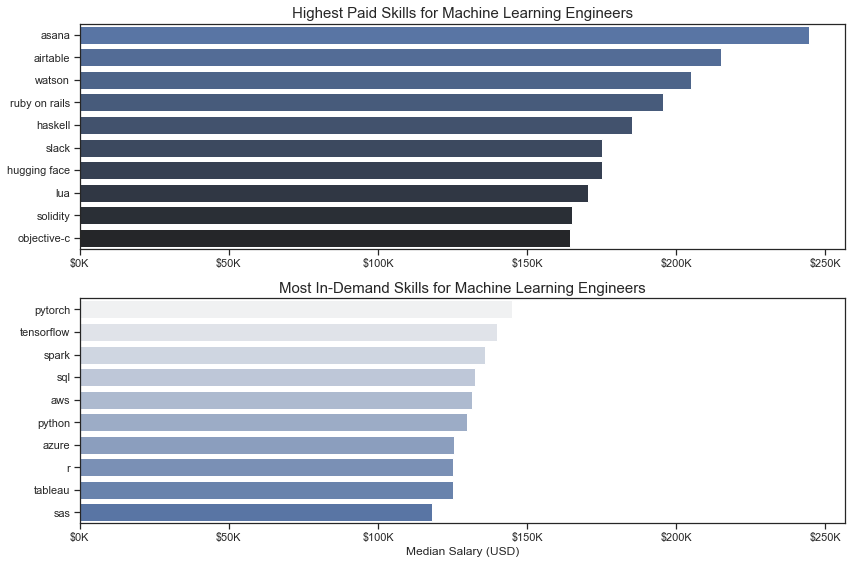

In [18]:
fig, ax = plt.subplots(2, 1,figsize=(12, 8))  

# Top 10 Highest Paid Skills for MLEs
sns.barplot(data=df_ml_top_pay, x='median', y=df_ml_top_pay.index, ax=ax[0], palette='dark:b_r')
ax[0].set_title('Highest Paid Skills for Machine Learning Engineers', fontsize=15)
ax[0].set_ylabel('')
ax[0].set_xlabel('')
ax[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${int(x/1000)}K'))


# Top 10 Most In-Demand Skills for MLEs' 
sns.barplot(data=df_ml_skills, x='median', y=df_ml_skills.index, ax=ax[1], palette='light:b')
ax[1].set_title('Most In-Demand Skills for Machine Learning Engineers', fontsize=15)
ax[1].set_ylabel('')
ax[1].set_xlabel('Median Salary (USD)')
ax[1].set_xlim(ax[0].get_xlim())  # Set the same x-axis limits as the first plot
ax[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${int(x/1000)}K'))

sns.set_theme(style='ticks')
plt.tight_layout()
plt.show();

##### Skills for Africa Market

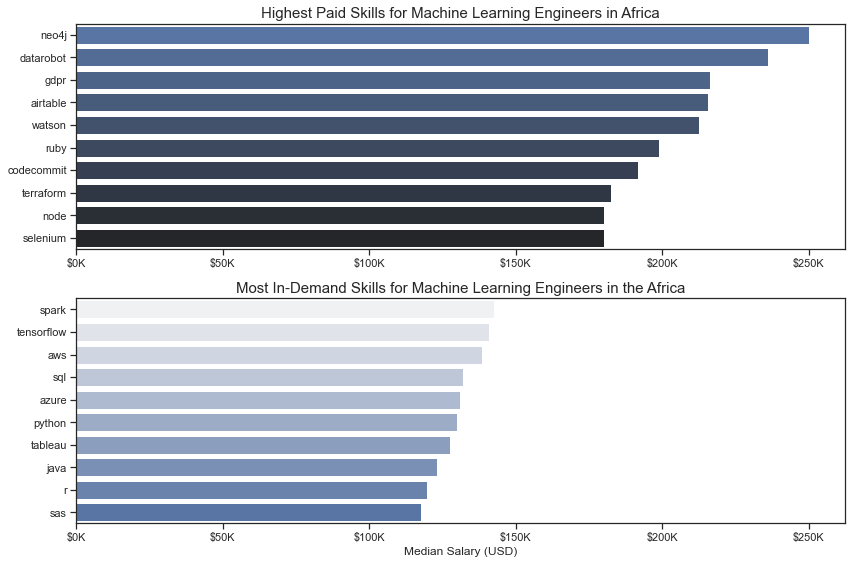

In [19]:
fig, ax = plt.subplots(2, 1,figsize=(12, 8))  

# Top 10 Highest Paid Skills for MLEs
sns.barplot(data=df_ml_africa_top_pay, x='median', y=df_ml_africa_top_pay.index, ax=ax[0], palette='dark:b_r')
ax[0].set_title('Highest Paid Skills for Machine Learning Engineers in Africa', fontsize=15)
ax[0].set_ylabel('')
ax[0].set_xlabel('')
ax[0].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${int(x/1000)}K'))


# Top 10 Most In-Demand Skills for MLEs' 
sns.barplot(data=df_ml_africa_skills, x='median', y=df_ml_africa_skills.index, ax=ax[1], palette='light:b')
ax[1].set_title('Most In-Demand Skills for Machine Learning Engineers in the Africa', fontsize=15)
ax[1].set_ylabel('')
ax[1].set_xlabel('Median Salary (USD)')
ax[1].set_xlim(ax[0].get_xlim())  # Set the same x-axis limits as the first plot
ax[1].xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'${int(x/1000)}K'))

sns.set_theme(style='ticks')
plt.tight_layout()
plt.show();